# MNIST 数据库

In [1]:
import torch
import torchvision

from torch import nn

from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

backend_inline.set_matplotlib_formats('svg')

In [2]:
## 导入MNIST数据
trans = torchvision.transforms.ToTensor()

def load_mnist(batch_size):
  mnist_train = torchvision.datasets.MNIST(root="../data", train=True, transform=trans, download=True)
  mnist_test = torchvision.datasets.MNIST(root="../data", train=False, transform=trans, download=True)
  train_iter = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True)
  test_iter = torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False)
  return train_iter, test_iter

## 准确度
def accuracy(y_hat, y):
  y_hat = y_hat.argmax(dim=1)
  cmp = y_hat.type(y.dtype) == y
  return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):
  net.eval()
  num_correct = 0
  num_total = 0
  with torch.no_grad():
    for X, y in data_iter:
      num_correct += accuracy(net(X), y)
      num_total += y.numel()
  return num_correct / num_total

## 参数初始化
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight,std=0.01)

## 训练（一个迭代周期）
def train_epoch(net, train_iter, loss, updater):
  net.train()
  for X, y in train_iter:
    y_hat = net(X)
    l = loss(y_hat, y)
    updater.zero_grad()
    l.backward()
    updater.step()

## 训练模型
def train(net, train_iter, test_iter, loss, num_epochs, updater):
  for epoch in range(num_epochs):
    train_epoch(net, train_iter, loss, updater)
    acc = evaluate_accuracy(net, test_iter)
    print(f'epoch {epoch + 1}, accuracy {acc:f}')

In [3]:
## 数据集可视化
def show_images(imgs, num_rows, num_cols, titles=None):
  _, axes = plt.subplots(num_rows, num_cols)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    ax.imshow(img)
    ax.axis('off')
    if titles:
      ax.set_title(titles[i])
  return axes

def show_mnist(num_rows, num_cols):
  fig_size = num_rows * num_cols
  train_iter, _ = load_mnist(batch_size=fig_size)
  for X, y in train_iter:
    break
  show_images(X.reshape(fig_size, 28, 28), num_rows, num_cols, titles=list(y.numpy()))

In [28]:
def show_predict(net, test_iter, n=9):
  for X, y in test_iter: break
  trues = list(y.numpy())
  preds = list(net(X).argmax(dim=1).numpy())
  titles = [f'{true}\n{pred}' for true, pred in zip(trues, preds)]
  show_images(X[0:n].reshape(n,28,28), 1, n, titles=titles[0:n])

使用 SELU 激活函数

In [5]:
## 超参数
num_inputs = 28*28
num_outputs = 10
num_hiddens = 256
batch_size = 256
learning_rate = 0.1
num_epochs = 10

train_iter, test_iter = load_mnist(batch_size)

## 模型
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(num_inputs, num_hiddens),
                    nn.SELU(),
                    nn.Linear(num_hiddens, num_outputs))
net.apply(init_weights)

## 损失函数
loss = nn.CrossEntropyLoss()

## 优化算法
trainer = torch.optim.SGD(net.parameters(), lr=learning_rate)

## 训练
train(net, train_iter, test_iter, loss, num_epochs, trainer)

epoch 1, accuracy 0.896600
epoch 2, accuracy 0.913200
epoch 3, accuracy 0.918400
epoch 4, accuracy 0.922500
epoch 5, accuracy 0.924200
epoch 6, accuracy 0.928000
epoch 7, accuracy 0.930200
epoch 8, accuracy 0.931400
epoch 9, accuracy 0.934400
epoch 10, accuracy 0.940200


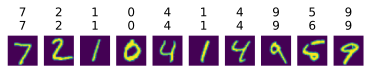

In [6]:
show_predict(net, test_iter, 10)

使用 ReLU 激活函数

In [7]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(num_inputs, num_hiddens),
                    nn.ReLU(),
                    nn.Linear(num_hiddens, num_outputs))
net.apply(init_weights)

## 损失函数
loss = nn.CrossEntropyLoss()

## 优化算法
trainer = torch.optim.SGD(net.parameters(), lr=learning_rate)

## 训练
train(net, train_iter, test_iter, loss, num_epochs, trainer)

epoch 1, accuracy 0.883100
epoch 2, accuracy 0.904600
epoch 3, accuracy 0.917700
epoch 4, accuracy 0.926100
epoch 5, accuracy 0.931600
epoch 6, accuracy 0.932400
epoch 7, accuracy 0.942200
epoch 8, accuracy 0.945400
epoch 9, accuracy 0.948200
epoch 10, accuracy 0.950100


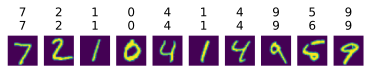

In [8]:
show_predict(net, test_iter, 10)

隐藏层增加至 1024 个元素

In [11]:
num_hiddens = 1024
learning_rate = 0.5
num_epochs = 10

train_iter, test_iter = load_mnist(batch_size)

## 模型
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(num_inputs, num_hiddens),
                    nn.ReLU(),
                    nn.Linear(num_hiddens, num_outputs))
net = torch.jit.script(net)
net.apply(init_weights)

## 损失函数
loss = nn.CrossEntropyLoss()

## 优化算法
trainer = torch.optim.SGD(net.parameters(), lr=learning_rate)

## 训练
train(net, train_iter, test_iter, loss, num_epochs, trainer)

epoch 1, accuracy 0.932800
epoch 2, accuracy 0.957100
epoch 3, accuracy 0.969100
epoch 4, accuracy 0.969900
epoch 5, accuracy 0.972400
epoch 6, accuracy 0.968900
epoch 7, accuracy 0.975900
epoch 8, accuracy 0.975800
epoch 9, accuracy 0.979700
epoch 10, accuracy 0.977900


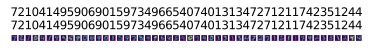

In [14]:
show_predict(net, test_iter, 50)

使用 GPU 加速计算（1）【推荐】

In [38]:
num_hiddens = 1024
learning_rate = 0.5
num_epochs = 10
gpu = torch.device('cuda')

def train_epoch(net, train_iter, loss, updater):
  net.train()
  for X, y in train_iter:
    X, y = X.to(gpu), y.to(gpu)
    y_hat = net(X)
    l = loss(y_hat, y)
    updater.zero_grad()
    l.backward()
    updater.step()

def evaluate_accuracy(net, data_iter):
  net.eval()
  num_correct = 0
  num_total = 0
  with torch.no_grad():
    for X, y in data_iter:
      X, y = X.to(gpu), y.to(gpu)
      num_correct += accuracy(net(X), y)
      num_total += y.numel()
  return num_correct / num_total


train_iter, test_iter = load_mnist(batch_size)

## 模型
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(num_inputs, num_hiddens),
                    nn.ReLU(),
                    nn.Linear(num_hiddens, num_outputs))
net = net.to(gpu)
net = torch.jit.script(net)
net.apply(init_weights)

## 损失函数
loss = nn.CrossEntropyLoss()
loss = loss.to(gpu)

## 优化算法
trainer = torch.optim.SGD(net.parameters(), lr=learning_rate)

## 训练
train(net, train_iter, test_iter, loss, num_epochs, trainer)

epoch 1, accuracy 0.942300
epoch 2, accuracy 0.954400
epoch 3, accuracy 0.962200
epoch 4, accuracy 0.964000
epoch 5, accuracy 0.976100
epoch 6, accuracy 0.974500
epoch 7, accuracy 0.976100
epoch 8, accuracy 0.977300
epoch 9, accuracy 0.977700
epoch 10, accuracy 0.979900


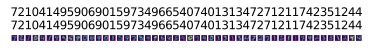

In [39]:
show_predict(net.to('cpu'), test_iter, 50)

使用 GPU 加速计算（2）【比第1个方法慢】

In [57]:
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate

def load_mnist(batch_size):
  mnist_train = torchvision.datasets.MNIST(root="../data", train=True, transform=trans, download=True)
  mnist_test = torchvision.datasets.MNIST(root="../data", train=False, transform=trans, download=True)
  train_iter = DataLoader(mnist_train, batch_size, shuffle=True,
                          collate_fn=lambda x: tuple(x_.to('cuda') for x_ in default_collate(x)))
  test_iter = DataLoader(mnist_test, batch_size, shuffle=False,
                         collate_fn=lambda x: tuple(x_.to('cuda') for x_ in default_collate(x)))
  return train_iter, test_iter

def evaluate_accuracy(net, data_iter):
  net.eval()
  num_correct = 0
  num_total = 0
  with torch.no_grad():
    for X, y in data_iter:
      num_correct += accuracy(net(X), y)
      num_total += y.numel()
  return num_correct / num_total

## 训练（一个迭代周期）
def train_epoch(net, train_iter, loss, updater):
  net.train()
  for X, y in train_iter:
    y_hat = net(X)
    l = loss(y_hat, y)
    updater.zero_grad()
    l.backward()
    updater.step()

In [48]:
num_hiddens = 1024
learning_rate = 0.5
num_epochs = 10

train_iter, test_iter = load_mnist(batch_size)

## 模型
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(num_inputs, num_hiddens),
                    nn.ReLU(),
                    nn.Linear(num_hiddens, num_outputs))
net = net.to(gpu)
net = torch.jit.script(net)
net.apply(init_weights)

## 损失函数
loss = nn.CrossEntropyLoss()
loss = loss.to(gpu)

## 优化算法
trainer = torch.optim.SGD(net.parameters(), lr=learning_rate)

## 训练
train(net, train_iter, test_iter, loss, num_epochs, trainer)

epoch 1, accuracy 0.937400
epoch 2, accuracy 0.955300
epoch 3, accuracy 0.960300
epoch 4, accuracy 0.971300
epoch 5, accuracy 0.974600
epoch 6, accuracy 0.975500
epoch 7, accuracy 0.975500
epoch 8, accuracy 0.978500
epoch 9, accuracy 0.979800
epoch 10, accuracy 0.980100


## 面向对象化

In [7]:
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
class A:
    def __init__(self):
        self.b = 1

a = A()
a.b

1

In [6]:
@d2l.add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)

a.do()

Class attribute "b" is 1


In [8]:
class B(d2l.HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)


self.a = 1 self.b = 2
There is no self.c = True


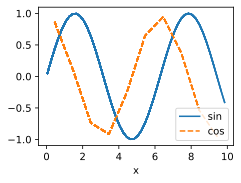

In [11]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

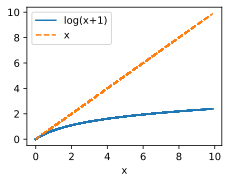

In [22]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
  board.draw(x, np.log(x+1), 'log(x+1)')
  board.draw(x, x, 'x')

### 线性回归

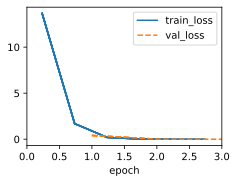

In [24]:
model = d2l.LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [25]:
model.get_w_b()

(tensor([[ 1.9985, -3.3935]]), tensor([4.1934]))

### Softmax 回归

In [26]:
from torch.nn import functional as F

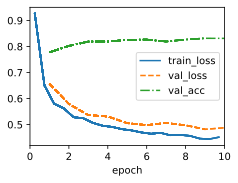

In [28]:
data = d2l.FashionMNIST(batch_size=256)
model = d2l.SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

### 多层感知机

In [33]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

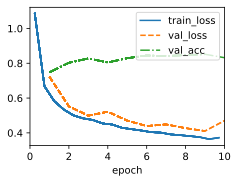

In [34]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

### 支持 GPU

In [36]:
@d2l.add_to_class(d2l.Trainer)  #@save
def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
    self.save_hyperparameters()
    self.gpus = [d2l.gpu(i) for i in range(min(num_gpus, d2l.num_gpus()))]

@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    if self.gpus:
        batch = [a.to(self.gpus[0]) for a in batch]
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_model(self, model):
    model.trainer = self
    model.board.xlim = [0, self.max_epochs]
    if self.gpus:
        model.to(self.gpus[0])
    self.model = model

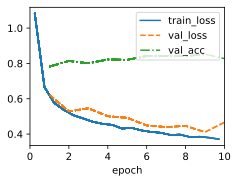

In [40]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)

In [41]:
trainer.gpus

[device(type='cuda', index=0)]

In [46]:
trainer.model

MLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

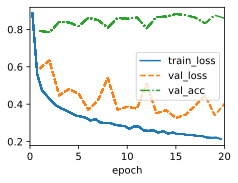

In [51]:
model = MLP(num_outputs=10, num_hiddens=1024, lr=0.5)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

### MNIST with OOP

In [61]:
from torchvision import transforms, datasets

In [64]:
class MNIST(d2l.DataModule):
    """The MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = datasets.MNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = datasets.MNIST(
            root=self.root, train=False, transform=trans, download=True)
        
    def text_labels(self, indices):
        """Return text labels."""
        return [int(i) for i in indices]

    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                           num_workers=self.num_workers)

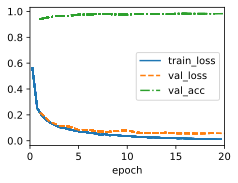

In [65]:
data = MNIST(batch_size=256)
model = MLP(num_outputs=10, num_hiddens=1024, lr=0.5)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

## 超参数：num_workers

In [6]:
from time import time
import multiprocessing as mp
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

mnist_train = MNIST(root="../data", train=True, transform=ToTensor(), download=True)

for num_workers in range(2, mp.cpu_count(), 2):  
  train_iter = DataLoader(mnist_train, shuffle=True, num_workers=num_workers,
                          batch_size=64, pin_memory=True)
  start = time()
  for epoch in range(1, 3):
      for i, data in enumerate(train_iter, 0):
          pass
  end = time()
  print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

Finish with:5.166165351867676 second, num_workers=2
Finish with:3.057523488998413 second, num_workers=4
Finish with:2.7206125259399414 second, num_workers=6
Finish with:2.674882173538208 second, num_workers=8
Finish with:2.7214133739471436 second, num_workers=10
Finish with:2.721066474914551 second, num_workers=12
Finish with:2.8338959217071533 second, num_workers=14
Finish with:2.8906192779541016 second, num_workers=16
Finish with:2.9868502616882324 second, num_workers=18
Finish with:3.06872820854187 second, num_workers=20
Finish with:3.177072048187256 second, num_workers=22
Finish with:3.1136956214904785 second, num_workers=24
Finish with:3.247370719909668 second, num_workers=26
Finish with:3.2936909198760986 second, num_workers=28
Finish with:3.3831615447998047 second, num_workers=30


In [7]:
for num_workers in range(2, mp.cpu_count(), 2):  
  train_iter = DataLoader(mnist_train, shuffle=True, num_workers=num_workers,
                          batch_size=256, pin_memory=True)
  start = time()
  for epoch in range(1, 3):
      for i, data in enumerate(train_iter, 0):
          pass
  end = time()
  print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

Finish with:3.7241764068603516 second, num_workers=2
Finish with:1.965907096862793 second, num_workers=4
Finish with:1.4557127952575684 second, num_workers=6
Finish with:1.3293750286102295 second, num_workers=8
Finish with:1.336336612701416 second, num_workers=10
Finish with:1.375279426574707 second, num_workers=12
Finish with:1.4263625144958496 second, num_workers=14
Finish with:1.4827406406402588 second, num_workers=16
Finish with:1.5194692611694336 second, num_workers=18
Finish with:1.544193983078003 second, num_workers=20
Finish with:1.745457410812378 second, num_workers=22
Finish with:1.8037714958190918 second, num_workers=24
Finish with:1.878176212310791 second, num_workers=26
Finish with:1.9637095928192139 second, num_workers=28
Finish with:2.063821792602539 second, num_workers=30


结论：num_workers=8 最快

## Pytorch Lightning

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from lightning import LightningModule, Trainer
from torchmetrics.functional import accuracy

In [3]:
class MNISTModel(LightningModule):
  def __init__(self, batch_size=256, num_hiddens=1024, lr=0.5, data_dir="../data", num_workers=8):
    super().__init__()
    self.batch_size = batch_size
    self.num_hiddens = num_hiddens
    self.lr = lr
    self.data_dir = data_dir
    self.num_workers = num_workers
    self.net = nn.Sequential(nn.Flatten(), nn.Linear(28*28, self.num_hiddens),
                             nn.ReLU(), nn.Linear(self.num_hiddens, 10))
    self.loss = nn.CrossEntropyLoss()
    self.trans = ToTensor()
    
  def forward(self, X):
    return self.net(X)
  
  def training_step(self, batch):
    X, y = batch
    y_hat = self.net(X)
    train_loss = self.loss(y_hat, y)
    self.log("train_loss", train_loss, prog_bar=True)
    return train_loss
  
  def test_step(self, batch):
    X, y = batch
    y_hat = self.net(X)
    test_loss = self.loss(y_hat, y)
    preds = torch.argmax(y_hat, dim=1)
    test_acc = accuracy(preds, y, task="multiclass", num_classes=10, average="micro")
    self.log("test_loss", test_loss, prog_bar=True)
    self.log("test_acc", test_acc, prog_bar=True)
    return test_loss
  
  def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=self.lr)
  
  def prepare_data(self):
    MNIST(root=self.data_dir, train=True, download=True)
    MNIST(root=self.data_dir, train=False, download=True)
  
  def setup(self, stage=None):
    self.mnist_train = MNIST(root="../data", train=True, transform=self.trans)
    self.mnist_test = MNIST(root="../data", train=False, transform=self.trans)
  
  def train_dataloader(self):
    return DataLoader(self.mnist_train, self.batch_size,
                      num_workers=self.num_workers, pin_memory=True, shuffle=True)
  
  def test_dataloader(self):
    return DataLoader(self.mnist_test, self.batch_size,
                      num_workers=self.num_workers, pin_memory=True, shuffle=False)

In [4]:
model = MNISTModel()
trainer = Trainer(max_epochs=10, log_every_n_steps=1)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2023-11-23 23:11:49.165877: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-23 23:11:49.297486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [5]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9797999858856201
        test_loss           0.06458669155836105
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.06458669155836105, 'test_acc': 0.9797999858856201}]